# Style Transfer

Let's try to do some style transfering via VGG

In [1]:
import torch
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def load_image(path, size=(256, 256)):
    im = Image.open(path).resize(size).convert("RGB")
    return transforms.ToTensor()(im)

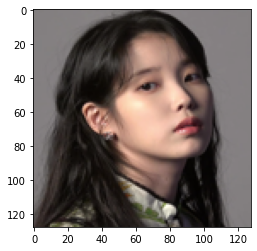

In [3]:
# content image
im_content = load_image("./images/iu.png", (128, 128))
plt.imshow(im_content.permute(1, 2, 0))

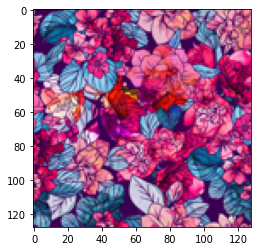

In [4]:
# style image
im_style = load_image("./images/pattern.png", (128, 128))
plt.imshow(im_style.permute(1, 2, 0))

## Load VGG & Get it Ready

In [5]:
device = "cuda"

In [6]:
from torchvision.models import vgg16

In [7]:
model = vgg16(pretrained=True).to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
def extract_features(model, layer_ids, inputs):
    ids = {i: True for i in layer_ids}
    output_list = []
    
    outputs = inputs
    
    for id in range(len(model.features)):
        outputs = model.features[id](outputs)
        if id in ids:
            output_list.append(outputs)               
    
    return output_list

ids = extract_features(model, [2, 4], im_content.to(device))
print(len(ids), ids[0].shape, ids[1].shape)

2 torch.Size([64, 128, 128]) torch.Size([64, 64, 64])


## Analyze Features

In the top range of the layers, we can see the style of the image. On the other sections, we can see the contents.
Let's give it a try.

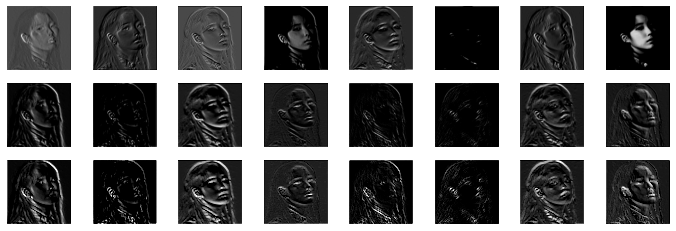

In [9]:
## Early
with torch.no_grad():
    f_early = extract_features(model, [0, 2, 4], im_content.to(device))

_, ax = plt.subplots(3, 8, figsize=(12, 4))
for row in range(3):
    for col in range(8):
        ax[row, col].imshow(f_early[row].cpu()[col], cmap="gray")
        ax[row, col].axis('off')

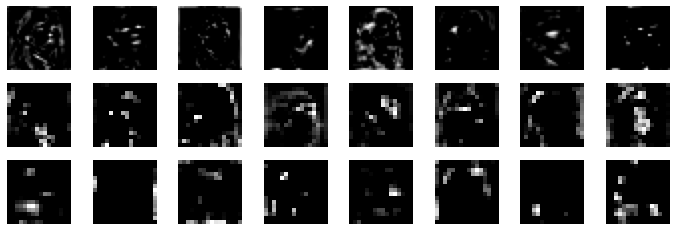

In [10]:
## Later
with torch.no_grad():
    f_later = extract_features(model, [14, 17, 21], im_content.to(device))

_, ax = plt.subplots(3, 8, figsize=(12, 4))
for row in range(3):
    for col in range(8):
        ax[row, col].imshow(f_later[row].cpu()[col], cmap="gray")
        ax[row, col].axis('off')

**See you can see the result**

In the first few layers, we can see the style of the image. But at the layer sections, it's optimized for different parts of the image.

### Let's try the same for the other image

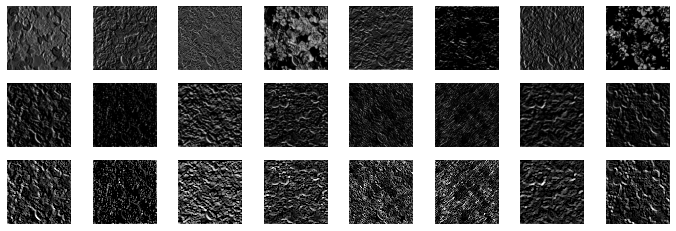

In [11]:
## Early
with torch.no_grad():
    f_early = extract_features(model, [0, 2, 4], im_style.to(device))

_, ax = plt.subplots(3, 8, figsize=(12, 4))
for row in range(3):
    for col in range(8):
        ax[row, col].imshow(f_early[row].cpu()[col], cmap="gray")
        ax[row, col].axis('off')

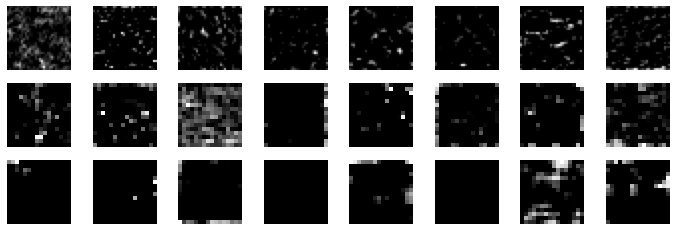

In [12]:
## Later
with torch.no_grad():
    f_later = extract_features(model, [14, 17, 21], im_style.to(device))

_, ax = plt.subplots(3, 8, figsize=(12, 4))
for row in range(3):
    for col in range(8):
        ax[row, col].imshow(f_later[row].cpu()[col], cmap="gray")
        ax[row, col].axis('off')

## Content Loss & Transfer It

In [13]:
## Define the loss
def calc_content_loss(model, layer_ids, source, target):
    
    f_source = extract_features(model, layer_ids, source)
    f_target = extract_features(model, layer_ids, target)
    
    total_loss = 0
    for s, t in zip(f_source, f_target):
        loss = torch.nn.L1Loss()(s, t)
        total_loss += loss
        
    return total_loss / len(layer_ids)

_source = load_image("./images/iu.png").to(device).requires_grad_(True)
_target = load_image("./images/pattern.png").to(device)
calc_content_loss(model, [14, 17, 21], _source, _target)

tensor(1.1279, device='cuda:0', grad_fn=<DivBackward0>)

In [14]:
## Content Transferring Loop
def transfer_content(layer_ids, content_weight = 1.0, lr=0.005):
    original = load_image("./images/iu.png")
    source = original.clone().to(device).requires_grad_(True)
    target = load_image("./images/pattern.png").to(device)
    optimizer = torch.optim.Adam([source], lr=lr)

    losses = []

    for i in tqdm(range(50)):
        optimizer.zero_grad()

        loss = calc_content_loss(model, layer_ids, source, target) * content_weight
        loss.backward()
        losses.append(loss.item())

        optimizer.step()

    _, ax = plt.subplots(1, 3, figsize=(12, 3))
    ax[0].plot(losses)
    ax[1].imshow(original.permute(1, 2, 0))
    ax[2].imshow(source.detach().cpu().permute(1, 2, 0).clip(0, 1))

### Trying to transfer early layers

  0%|          | 0/50 [00:00<?, ?it/s]

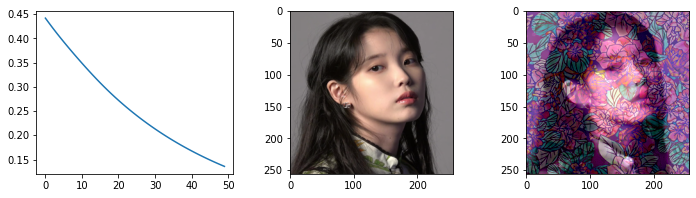

In [15]:
transfer_content([2])

  0%|          | 0/50 [00:00<?, ?it/s]

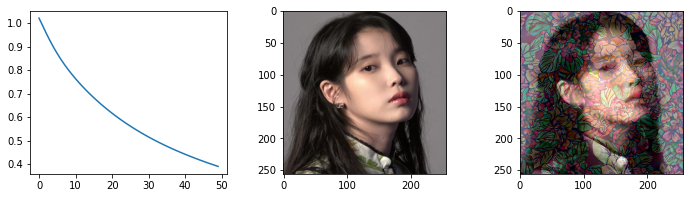

In [16]:
transfer_content([8])

  0%|          | 0/50 [00:00<?, ?it/s]

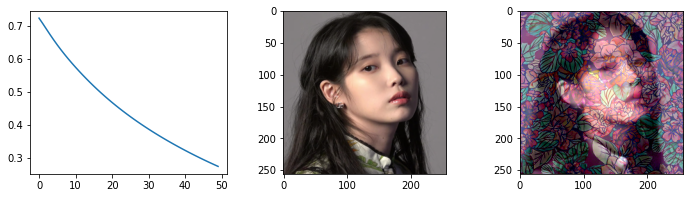

In [17]:
transfer_content([2, 4, 8])

### Trying to transfer later layers

  0%|          | 0/50 [00:00<?, ?it/s]

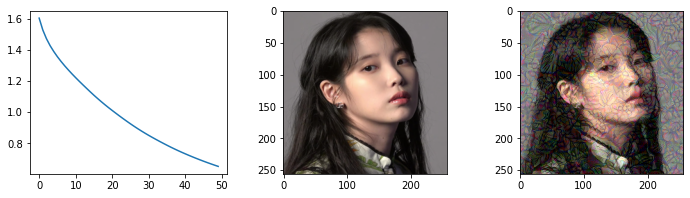

In [18]:
transfer_content([17])

  0%|          | 0/50 [00:00<?, ?it/s]

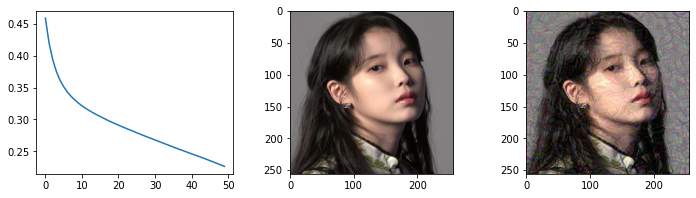

In [19]:
transfer_content([21])

  0%|          | 0/50 [00:00<?, ?it/s]

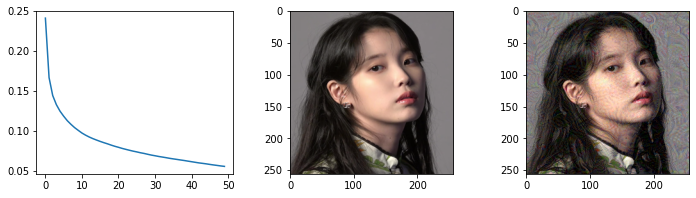

In [20]:
transfer_content([30])

  0%|          | 0/50 [00:00<?, ?it/s]

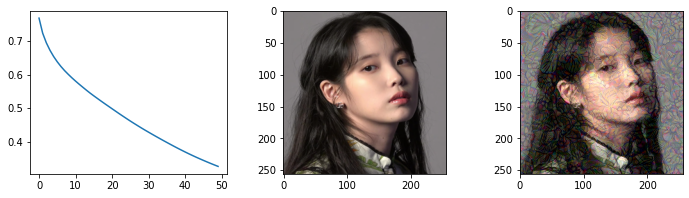

In [21]:
transfer_content([17, 21, 30])

### Content Transfer Summary

When trying to transfer content, we should try to do that for the later part of the layers.
Otherwise, they are not looking good.